In [8]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_confustion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from collections import Counter
from sklearn import metrics
from xgboost import XGBClassifier


In [3]:
path2data = r"C:\Users\samer\Documents\university\anfänger_praktikum\harambee\ej_formal_shareable.csv"
df = pd.read_csv(path2data)
df = df.drop("Unnamed: 0", axis=1)
df = df[df["job_category"].isin(["Unclassified"]) == False]
df.head(3)

label2id = {}
for idx, category in enumerate(df.job_category.unique().tolist()):
    label2id[category] = idx


id2label = {}
for k,v in label2id.items():
    id2label[v] = k
    
df['label'] = df['job_category'].apply(lambda x :label2id[x])
df['tokenized_text'] = df.job_title.apply(lambda x:str.lower(x).split(" "))
df
df.head(3)

,job_title,frequency,job_category,label,tokenized_text
0,Cleaner,118,cleaner,0,[cleaner]
1,Education assistant,95,education assistant,1,"[education, assistant]"
2,Driver,91,driver,2,[driver]


<BarContainer object of 38 artists>

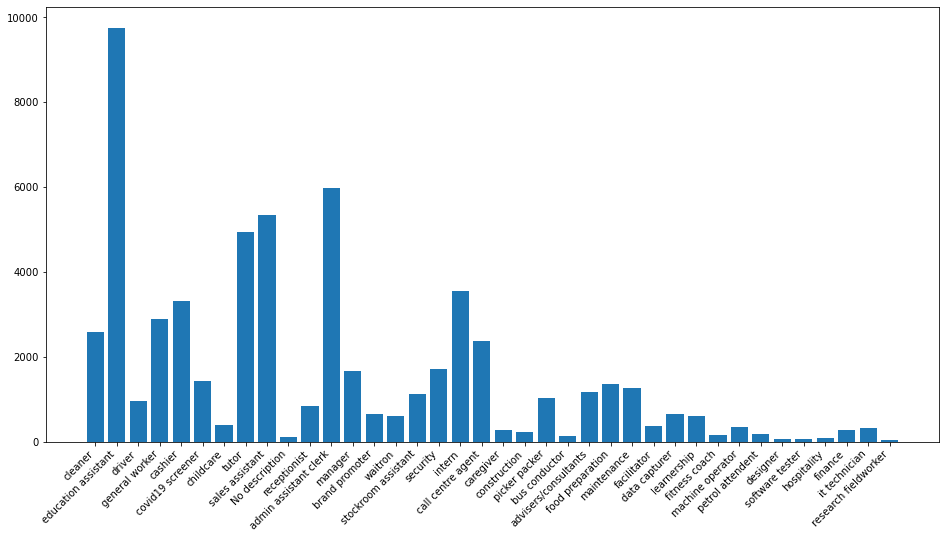

In [9]:
df_counter = Counter(df.job_category)
plt.figure(figsize=(16,8))
plt.xticks(rotation=45, ha='right')
plt.bar(df_counter.keys(), df_counter.values())

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (df['tokenized_text'], df['label'] , test_size=0.2)

# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=128,
                                   window=5,
                                   min_count=2)

In [11]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

C:\Users\samer\AppData\Local\Temp\ipykernel_24064\22094319.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\samer\AppData\Local\Temp\ipykernel_24064\22094319.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [12]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(128, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(128, dtype=float))

In [13]:
# Instantiate and fit a basic Random Forest model on top of the vectors
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, list(y_train.values))

In [14]:
len(X_test_vect_avg[0])

128

In [15]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [16]:
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.941 / Recall: 0.939 / Accuracy: 0.939


In [17]:
f1_score(y_test, y_pred, average='weighted')

0.939041619022845

In [18]:
print(classification_report(y_test, y_pred, target_names= list(id2label.values()))) #

                       precision    recall  f1-score   support

              cleaner       0.75      0.92      0.83       503
  education assistant       0.98      0.98      0.98      1969
               driver       0.98      0.87      0.92       198
       general worker       0.98      0.99      0.98       564
              cashier       0.92      0.90      0.91       669
     covid19 screener       0.97      0.97      0.97       276
            childcare       0.88      0.86      0.87        78
                tutor       0.96      0.98      0.97       972
      sales assistant       0.95      0.94      0.94      1075
       No description       1.00      0.68      0.81        31
         receptionist       0.96      0.90      0.93       182
admin assistant clerk       0.95      0.96      0.95      1191
              manager       0.96      0.92      0.94       361
       brand promoter       0.91      0.92      0.92       124
              waitron       0.94      0.91      0.92  

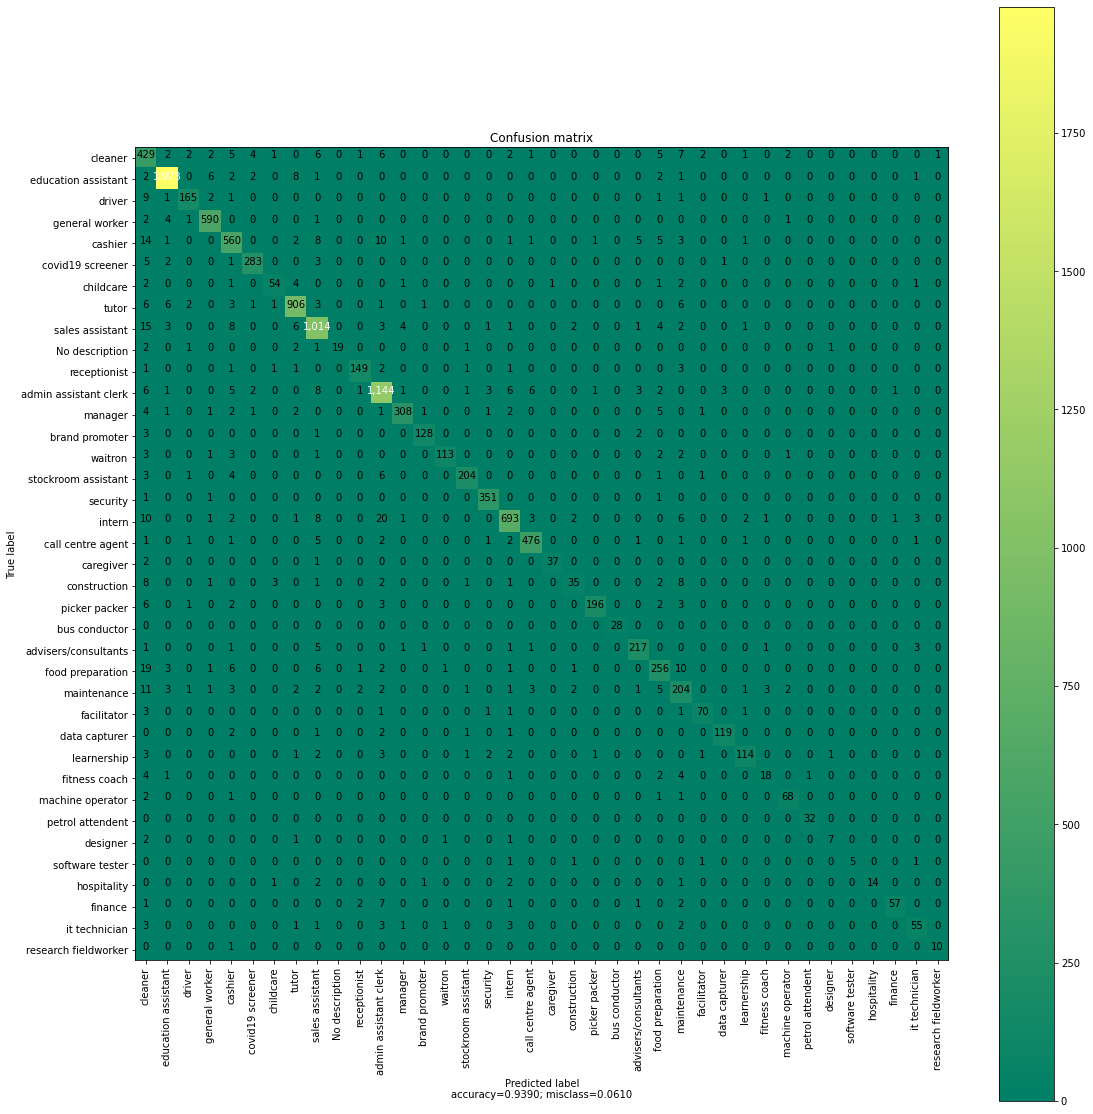

In [117]:
x = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(x, list(id2label.values()),cmap='summer')

## test classification_algorithm

In [73]:
def get_prediction(model,text):
    
    ##
    ## encode text
    encoded_text = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in text])
    
    ## sentence vector by averaging vector
    avg_test_vec = []
    for v in encoded_text:
        if v.size:
            avg_test_vec.append(v.mean(axis=0))
        else:
            avg_test_vec.append(np.zeros(128, dtype=float))
    predicts = model.predict(avg_test_vec)

    return predicts

def preb_dataframe(df):
    df['tokenized_text'] = df.job_title.apply(lambda x:x.split(" "))
    test_set = df.sample(5000)
    test_jobs = test_set.tokenized_text.tolist()
    return df, test_set


In [140]:
path2data = r"C:\Users\samer\Documents\university\anfänger_praktikum\harambee\ej_formal_shareable.csv"
df_ = pd.read_csv(path2data)
df_ = df_.drop("Unnamed: 0", axis=1)
df_ = df_[df_["job_category"].isin(["Unclassified"]) == False]
df_['label'] = df_['job_category'].apply(lambda x :label2id[x])
df_['tokenized_text'] = df_.job_title.apply(lambda x:str.lower(x).split(" ")) #

test_set = df_.sample(5000)
test_jobs = test_set.tokenized_text.tolist()

predicts = get_prediction(rf_model,test_jobs)
test_set['predicts'] = predicts
test_set['category predicted'] = test_set['predicts'].apply(lambda x :id2label[x])
test_set



C:\Users\samer\AppData\Local\Temp\ipykernel_15904\1331782833.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded_text = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


,job_title,frequency,job_category,label,tokenized_text,predicts,category predicted
54272,Promoter,1,brand promoter,13,"[promoter, ]",13,brand promoter
78434,Admin and finance clerk,1,admin assistant clerk,11,"[admin, and, finance, clerk]",11,admin assistant clerk
22206,Educator Assistant,1,education assistant,1,"[educator, assistant, ]",1,education assistant
59746,screener,1,covid19 screener,5,[screener],5,covid19 screener
19873,Warehouse and Customer Support,1,cleaner,0,"[warehouse, and, customer, support]",0,cleaner
...,...,...,...,...,...,...,...
75749,Administrator,1,admin assistant clerk,11,"[administrator, ]",11,admin assistant clerk
70888,administration,1,admin assistant clerk,11,"[administration, ]",11,admin assistant clerk
2362,Supervisor,2,manager,12,[supervisor],12,manager
20141,Shop assistant,1,sales assistant,8,"[shop, assistant, ]",8,sales assistant


In [137]:
Counter(list(test_set['job_category'] == test_set['category predicted']))

Counter({True: 4902, False: 98})

In [143]:
from sklearn.manifold import TSNE


In [141]:
test_set[test_set['job_category'] != test_set['category predicted']].head(20)

,job_title,frequency,job_category,label,tokenized_text,predicts,category predicted
31167,Ecd educator,1,childcare,6,"[ecd, educator, ]",7,tutor
20782,Retail worker,1,sales assistant,8,"[retail, worker, ]",0,cleaner
48846,Taxi Driver Assistant,1,driver,2,"[taxi, driver, assistant, ]",29,fitness coach
4469,Teachers's assistant,1,tutor,7,"[teachers's, assistant]",8,sales assistant
6250,Cashier/sales lady & cleaner,1,cashier,4,"[cashier/sales, lady, &, cleaner]",0,cleaner
4907,Storeman and Merchandiser,1,sales assistant,8,"[storeman, and, merchandiser, ]",4,cashier
25034,Branch Manager/Sales Consultant,1,sales assistant,8,"[branch, manager/sales, consultant, ]",23,advisers/consultants
17553,Shop assistance/ cashier,1,cashier,4,"[shop, assistance/, cashier]",7,tutor
43825,Receptionist/Administration,1,admin assistant clerk,11,[receptionist/administration],0,cleaner
31584,Driving.boilermaker.welding,1,maintenance,25,[driving.boilermaker.welding],0,cleaner
